In [681]:
#Environment setup
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
#libraries loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [682]:
data_doge = pd.read_csv("DOGE-USD.csv")# Data loading


data_doge.head()#data viewing

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,doge_usd
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,doge_usd
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,doge_usd
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,doge_usd
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,doge_usd


In [683]:
data_doge['Close'].value_counts() 

0.002653    5
0.002054    4
0.002404    4
0.002779    4
0.002595    4
           ..
0.002690    1
0.002492    1
0.002482    1
0.002620    1
0.084258    1
Name: Close, Length: 1619, dtype: int64

In [684]:
df = data_doge.loc[(data_doge['key'] == 'doge_usd')]
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,doge_usd
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,doge_usd
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,doge_usd
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,doge_usd
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,doge_usd
5,2017-11-14,0.001201,0.001239,0.001131,0.001184,0.001184,2660340,doge_usd
6,2017-11-15,0.001189,0.001351,0.001179,0.001339,0.001339,2840180,doge_usd
7,2017-11-16,0.001348,0.001424,0.001286,0.001390,0.001390,3423010,doge_usd
8,2017-11-17,0.001381,0.001394,0.001274,0.001313,0.001313,2787480,doge_usd
9,2017-11-18,0.001308,0.001385,0.001254,0.001373,0.001373,1648260,doge_usd


In [685]:
#date time collection
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > pd.to_datetime('2017-11-09')]

In [686]:
df = df[['Date','Open','Close','High','Low','Volume']]

In [687]:
df.head()

,Date,Open,Close,High,Low,Volume
1,2017-11-10,0.001421,0.001163,0.001431,0.001125,4246520
2,2017-11-11,0.001146,0.001201,0.001257,0.001141,2231080
3,2017-11-12,0.001189,0.001038,0.001210,0.001002,3288960
4,2017-11-13,0.001046,0.001211,0.001212,0.001019,2481270
5,2017-11-14,0.001201,0.001184,0.001239,0.001131,2660340


In [688]:
df = df[['Close']]

In [689]:
dataset = df.values
dataset = dataset.astype('float32')

In [690]:
dataset

array([[0.001163],
       [0.001201],
       [0.001038],
       ...,
       [0.084765],
       [0.084672],
       [0.084258]], dtype=float32)

In [691]:
#Rescaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scale = scaler.fit_transform(dataset)

In [692]:
dataset_scale

array([[0.00018282],
       [0.00023839],
       [0.        ],
       ...,
       [0.12245462],
       [0.1223186 ],
       [0.1217131 ]], dtype=float32)

In [693]:
#training set size
train_size = int(len(dataset_scale) * 0.8123)
test_size = len(dataset_scale) - train_size
train, test = dataset_scale[0:train_size, :], dataset_scale[train_size:len(dataset), :]
print(len(train), len(test))

1491 345


In [694]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [695]:
look_back = 20
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [696]:
#trainX
#trainY
#testX
#testY

In [697]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [698]:
#Model set-up
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='nadam')
model.fit(trainX, trainY, epochs=600, batch_size=300, verbose=2)

Epoch 1/600
5/5 - 1s - loss: 0.0617 - 1s/epoch - 216ms/step
Epoch 2/600
5/5 - 0s - loss: 0.0564 - 11ms/epoch - 2ms/step
Epoch 3/600
5/5 - 0s - loss: 0.0512 - 11ms/epoch - 2ms/step
Epoch 4/600
5/5 - 0s - loss: 0.0463 - 11ms/epoch - 2ms/step
Epoch 5/600
5/5 - 0s - loss: 0.0419 - 12ms/epoch - 2ms/step
Epoch 6/600
5/5 - 0s - loss: 0.0380 - 11ms/epoch - 2ms/step
Epoch 7/600
5/5 - 0s - loss: 0.0347 - 12ms/epoch - 2ms/step
Epoch 8/600
5/5 - 0s - loss: 0.0318 - 10ms/epoch - 2ms/step
Epoch 9/600
5/5 - 0s - loss: 0.0292 - 12ms/epoch - 2ms/step
Epoch 10/600
5/5 - 0s - loss: 0.0269 - 12ms/epoch - 2ms/step
Epoch 11/600
5/5 - 0s - loss: 0.0248 - 12ms/epoch - 2ms/step
Epoch 12/600
5/5 - 0s - loss: 0.0227 - 11ms/epoch - 2ms/step
Epoch 13/600
5/5 - 0s - loss: 0.0208 - 11ms/epoch - 2ms/step
Epoch 14/600
5/5 - 0s - loss: 0.0190 - 12ms/epoch - 2ms/step
Epoch 15/600
5/5 - 0s - loss: 0.0172 - 11ms/epoch - 2ms/step
Epoch 16/600
5/5 - 0s - loss: 0.0154 - 10ms/epoch - 2ms/step
Epoch 17/600
5/5 - 0s - loss: 0.0

Epoch 134/600
5/5 - 0s - loss: 9.1481e-04 - 11ms/epoch - 2ms/step
Epoch 135/600
5/5 - 0s - loss: 9.1302e-04 - 11ms/epoch - 2ms/step
Epoch 136/600
5/5 - 0s - loss: 9.0906e-04 - 10ms/epoch - 2ms/step
Epoch 137/600
5/5 - 0s - loss: 9.0706e-04 - 12ms/epoch - 2ms/step
Epoch 138/600
5/5 - 0s - loss: 9.0190e-04 - 11ms/epoch - 2ms/step
Epoch 139/600
5/5 - 0s - loss: 8.9941e-04 - 11ms/epoch - 2ms/step
Epoch 140/600
5/5 - 0s - loss: 8.9625e-04 - 10ms/epoch - 2ms/step
Epoch 141/600
5/5 - 0s - loss: 8.9329e-04 - 11ms/epoch - 2ms/step
Epoch 142/600
5/5 - 0s - loss: 8.9260e-04 - 11ms/epoch - 2ms/step
Epoch 143/600
5/5 - 0s - loss: 8.8662e-04 - 11ms/epoch - 2ms/step
Epoch 144/600
5/5 - 0s - loss: 8.8370e-04 - 11ms/epoch - 2ms/step
Epoch 145/600
5/5 - 0s - loss: 8.8159e-04 - 11ms/epoch - 2ms/step
Epoch 146/600
5/5 - 0s - loss: 8.7732e-04 - 11ms/epoch - 2ms/step
Epoch 147/600
5/5 - 0s - loss: 8.7575e-04 - 11ms/epoch - 2ms/step
Epoch 148/600
5/5 - 0s - loss: 8.7190e-04 - 11ms/epoch - 2ms/step
Epoch 149/

5/5 - 0s - loss: 6.3612e-04 - 11ms/epoch - 2ms/step
Epoch 259/600
5/5 - 0s - loss: 6.3481e-04 - 12ms/epoch - 2ms/step
Epoch 260/600
5/5 - 0s - loss: 6.3038e-04 - 11ms/epoch - 2ms/step
Epoch 261/600
5/5 - 0s - loss: 6.2818e-04 - 10ms/epoch - 2ms/step
Epoch 262/600
5/5 - 0s - loss: 6.2957e-04 - 11ms/epoch - 2ms/step
Epoch 263/600
5/5 - 0s - loss: 6.2503e-04 - 11ms/epoch - 2ms/step
Epoch 264/600
5/5 - 0s - loss: 6.2439e-04 - 11ms/epoch - 2ms/step
Epoch 265/600
5/5 - 0s - loss: 6.2186e-04 - 11ms/epoch - 2ms/step
Epoch 266/600
5/5 - 0s - loss: 6.2318e-04 - 11ms/epoch - 2ms/step
Epoch 267/600
5/5 - 0s - loss: 6.2079e-04 - 11ms/epoch - 2ms/step
Epoch 268/600
5/5 - 0s - loss: 6.1864e-04 - 11ms/epoch - 2ms/step
Epoch 269/600
5/5 - 0s - loss: 6.1633e-04 - 10ms/epoch - 2ms/step
Epoch 270/600
5/5 - 0s - loss: 6.1431e-04 - 11ms/epoch - 2ms/step
Epoch 271/600
5/5 - 0s - loss: 6.1485e-04 - 11ms/epoch - 2ms/step
Epoch 272/600
5/5 - 0s - loss: 6.1172e-04 - 11ms/epoch - 2ms/step
Epoch 273/600
5/5 - 0s -

Epoch 383/600
5/5 - 0s - loss: 4.7734e-04 - 11ms/epoch - 2ms/step
Epoch 384/600
5/5 - 0s - loss: 4.7707e-04 - 11ms/epoch - 2ms/step
Epoch 385/600
5/5 - 0s - loss: 4.7437e-04 - 11ms/epoch - 2ms/step
Epoch 386/600
5/5 - 0s - loss: 4.7502e-04 - 11ms/epoch - 2ms/step
Epoch 387/600
5/5 - 0s - loss: 4.7485e-04 - 10ms/epoch - 2ms/step
Epoch 388/600
5/5 - 0s - loss: 4.7199e-04 - 11ms/epoch - 2ms/step
Epoch 389/600
5/5 - 0s - loss: 4.7285e-04 - 11ms/epoch - 2ms/step
Epoch 390/600
5/5 - 0s - loss: 4.7446e-04 - 11ms/epoch - 2ms/step
Epoch 391/600
5/5 - 0s - loss: 4.6934e-04 - 11ms/epoch - 2ms/step
Epoch 392/600
5/5 - 0s - loss: 4.6800e-04 - 11ms/epoch - 2ms/step
Epoch 393/600
5/5 - 0s - loss: 4.6874e-04 - 11ms/epoch - 2ms/step
Epoch 394/600
5/5 - 0s - loss: 4.6890e-04 - 12ms/epoch - 2ms/step
Epoch 395/600
5/5 - 0s - loss: 4.6998e-04 - 11ms/epoch - 2ms/step
Epoch 396/600
5/5 - 0s - loss: 4.6760e-04 - 11ms/epoch - 2ms/step
Epoch 397/600
5/5 - 0s - loss: 4.6576e-04 - 11ms/epoch - 2ms/step
Epoch 398/

5/5 - 0s - loss: 3.9099e-04 - 12ms/epoch - 2ms/step
Epoch 508/600
5/5 - 0s - loss: 3.9172e-04 - 11ms/epoch - 2ms/step
Epoch 509/600
5/5 - 0s - loss: 3.8927e-04 - 10ms/epoch - 2ms/step
Epoch 510/600
5/5 - 0s - loss: 3.9040e-04 - 11ms/epoch - 2ms/step
Epoch 511/600
5/5 - 0s - loss: 3.9005e-04 - 11ms/epoch - 2ms/step
Epoch 512/600
5/5 - 0s - loss: 3.8995e-04 - 11ms/epoch - 2ms/step
Epoch 513/600
5/5 - 0s - loss: 3.8887e-04 - 11ms/epoch - 2ms/step
Epoch 514/600
5/5 - 0s - loss: 3.8757e-04 - 11ms/epoch - 2ms/step
Epoch 515/600
5/5 - 0s - loss: 3.8838e-04 - 11ms/epoch - 2ms/step
Epoch 516/600
5/5 - 0s - loss: 3.8780e-04 - 11ms/epoch - 2ms/step
Epoch 517/600
5/5 - 0s - loss: 3.8692e-04 - 11ms/epoch - 2ms/step
Epoch 518/600
5/5 - 0s - loss: 3.8565e-04 - 11ms/epoch - 2ms/step
Epoch 519/600
5/5 - 0s - loss: 3.8618e-04 - 11ms/epoch - 2ms/step
Epoch 520/600
5/5 - 0s - loss: 3.8601e-04 - 10ms/epoch - 2ms/step
Epoch 521/600
5/5 - 0s - loss: 3.8584e-04 - 11ms/epoch - 2ms/step
Epoch 522/600
5/5 - 0s -

In [699]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

11/11 [==============================] - 0s 863us/step


In [700]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [701]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


In [702]:
from sklearn.metrics import mean_squared_error

mean_squared_error(testY[0].reshape(-1),testPredict[:, 0])


6.0487646264188376e-05

In [703]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [704]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

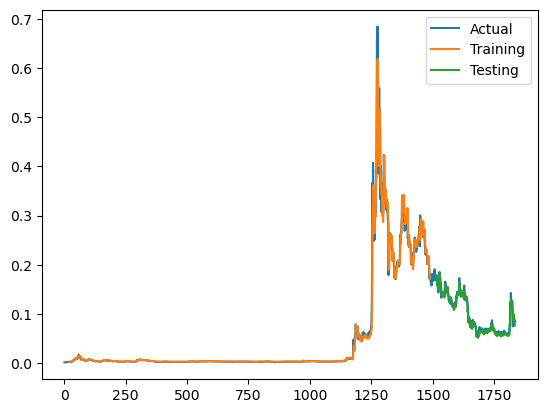

In [705]:
plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [706]:
    from keras.models import load_model
    model.save('doge-nadam.h5') 
    model.save_weights('doge_nadam_weights.h5')  # to store